# 1D Three Phase Simulation of Alloys and PINN model development 


This notebook contains the simulation of 1D Phase change of aluminium alloy. There will be three phases (solid,liquid and mushy).   

The approach used is finite difference method and the physics involved in heat conduction.

Import Libraries

In [9]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from ht_sim import sim1d


Define the constants and initial conditions

Material :- AL 380

| Sr.No | Properties  | Symbol | Value  | Unit |Range(source) |
|:---:|:---:|:---:|:---:|:---:|:--:|
| 1  | Liquidus Density | $\rho_{l}$  | 2300 | $kg/m^3$  |  2200-2400 (ASM handbook) |
|  2 |  Solidus Density  |  $\rho_{s}$  | 2500  |  $kg/m^3$  | 2400-2600 (ASM handbook) |
|  3 |  Mushy Desnity |  $\rho_{m}$  |  2400 | $kg/m^3$   |Increase linearly from liquid to solid (ASM handbook) |
|  4 |  Liquidus Thermal Conductivity| $k_l$  |  70 | $W/m-K$  |60-80 (ASM handbook) |
|  5 |  Solidus Thermal Conductivity | $k_s$  | 180  |  $W/m-K$ | 150-210(ASM handbook) |
|  6 | Mushy Zone Thermal Conductivity | $k_m$  | 125  |  $W/m-K$ |Decrease linearly from liquid to solid (ASM handbook) |
|  7 | Liquidus Specific Heat | $c_{pl}$  | 1190  | $J/kg-K$  | 1100 -1200 (ASM handbook)|
|  8 | Solidus Specific Heat | $c_{ps}$  |  1100 |  $J/kg-K$  | 1100-1200 (ASM handbook)|
|  9 | Mushy Zone Specific Heat |  $c_{pm}$ | 1175 | $J/kg-K$   |decrease lineraly from liquid to solid (ASM handbook)|
|  10 | Latent Heat of Fusion | $L_{fusion}$  | 450e3  | $J/kg$ | (400-500)e3 (ASM handbook) |
| 11 | Left Boundary Temperature |$BCT_{l}$|623 |$K$| (623-723) Nissan Data |
|12 | Right Boundary Temperature | $BCT_{r}$|623 |$K$| (623-723) Nissan Data |
|13| Freezing time | |60 |sec|||

In [10]:
# Geometry
length = 15e-3             # Length of the rod

# Material properties
rho = 2500                      # Density of AL380 (kg/m^3)
rho_l = 2300
rho_s = 2600
rho_m = (rho_l + rho_s )/2       # Desnity in mushy zone is taken as average of liquid and solid density

k = 80.0                        # W/m-K
k_l = k                       # W/m-K
k_s = 210.0                      # W/m-K
k_m =  (k_l+k_s)/2                     # W/m-K

cp = 1195                       # Specific heat of aluminum (J/kg-K)
cp_l = cp
cp_s = 1100
cp_m =  (cp_l+cp_s)/2                 # Specific heat of mushy zone is taken as average of liquid and solid specific heat

           # Thermal diffusivity
alpha_l = k_l / (rho_l * cp_l)
alpha_s = k_s / (rho_s*cp_s)
alpha_m = k_m / (rho_m * cp_m)          #`Thermal diffusivity in mushy zone is taken as average of liquid and solid thermal diffusivity`
print (f"alpha_l = {alpha_l}, alpha_s = {alpha_s}, alpha_m = {alpha_m}")

#L_fusion = 3.9e3                 # J/kg
L_fusion = 500e3               # J/kg  # Latent heat of fusion of aluminum
         # Thermal diffusivity

    
                          # Spatial discretization

num_points = 50                        # Number of spatial points
dx = length / (num_points - 1)         # Distance between two spatial points
print('dx is',dx)
                                   #dt = time_end/num_steps
#num_steps = 200000               # Number of time steps
                                  # num_steps = round(time_end/dt)
                                                              
                            # Time Discretization  
# 
time_end = 5          # seconds                         
#num_steps = 10000
# dt = time_end/num_steps
maxi = max(alpha_s,alpha_l,alpha_m)
dt = abs(0.5*((dx**2) /maxi))

print('dt is ',dt)
num_steps = round(time_end/dt)+1
print('num_steps is',num_steps)
cfl = 0.5 *(dx**2/max(alpha_l,alpha_s,alpha_m))
print('cfl is',cfl)
#dt = time_end / num_steps
time_steps = np.linspace(0, time_end, num_steps + 1)
step_coeff = dt / (dx ** 2)
if dt <= cfl:
    print('stability criteria satisfied')
else:
    print('stability criteria not satisfied')
    sys.exit()

alpha_l = 2.9106785519374202e-05, alpha_s = 7.342657342657342e-05, alpha_m = 5.157618602996754e-05
dx is 0.0003061224489795918
dt is  0.00063812697090498
num_steps is 7836
cfl is 0.00063812697090498
stability criteria satisfied


### Initial and Boundary Conditions

In [15]:
# Initial Conditions
T_L = 889.0                       #  K -Liquidus Temperature (616 c) AL 380
T_S = 823.0                      # K- Solidus Temperature (550 C)
m_eff =(k_m/(rho_m*(cp_m-(L_fusion/(T_L-T_S)))))
# cross verify the values of the liquidus and solidus from flowcast software
htc = -9000.0                   # W/m^2-K
q = htc*(919.0-313.0)

# Initial temperature and phase fields
temperature = np.full(num_points, 919.0)
phase = np.zeros(num_points)*1.0

# Set boundary conditions
temperature[-1] = 313.0 #(40 C)
phase[-1] = 1.0

temperature[0] = 313.0 #(40 C)
phase[0] = 1.0

# Store initial state in history
temperature_history = [temperature.copy()]
phi_history = [phase.copy()]

# print(temperature_history,phi_history)

Solving the heat transfer equation and phase change using numerical methods

In [12]:
# Finite difference method

for m in range(1, num_steps+1):                  # time loop
    
    temperature[0] = temperature[1] + (q*dx /k_s) # Boundary condition at x=0
    temperature[-1] = temperature[-2] + (q*dx /k_s) # Boundary condition at x=L
    #print(f"Step {m}, point {n},Temperature: {temperature}, Phase: {phase}")

    
    for n in range(1,num_points-1):              # space loop, adjusted range
       
        if temperature[n] >= T_L:
            temperature[n] = temperature[n] + ((alpha_l * dt )/ dx**2) * (temperature[n+1] - 2.0 * temperature[n] + temperature[n-1])
            phase[n] = 0
         
            #print(m,n,temperature[n],phase[n])
        elif T_S < temperature[n] < T_L:
            #temperature[n] = temperature[n] - (((k * dt) / (rho*(T_L-T_S)*(cp*(T_L-T_S)-L_fusion)*(dx**2))) * (temperature[n+1] - 2 * temperature[n] + temperature[n-1]))
            temperature[n] = temperature[n] - ((m_eff * step_coeff)* (temperature[n+1] - 2 * temperature[n] + temperature[n-1]))
            phase[n] = (T_L - temperature[n]) / (T_L - T_S)
            #print(m,n,temperature[n],phase[n])
         
        elif temperature[n]<T_S:
            temperature[n] = temperature[n] + ((alpha_s * dt )/ dx**2) * (temperature[n+1] - 2.0 * temperature[n] + temperature[n-1])
            phase[n] = 1
            
        else:
            print("ERROR: should not be here")
         
           # print(m,n,temperature[n],phase[n])
    temperature = temperature.copy()
    temperature_history.append(temperature.copy()) # Append the temperature history to add ghost points
    phi_history.append(phase.copy())  # Append the phase history to add ghost points
    #Print for debugging
    #print(f"Step {m}, space{n},Temperature: {temperature}, Phase: {phase}")


#print(temperature_history)
#print(phi_history)




Using max function for removing the if and else framework

 Finite difference method

for m in range(1, num_steps+1):                  # time loop
                # space loop, adjusted range
        
    temp_n = temperature[1:num_points-1]
    #print('temp_n is',temp_n)
    c1_val = np.maximum(temp_n - T_L,0) / np.where(temp_n- T_L!=0, temp_n - T_L, 1)
    c1_val = np.where(c1_val == 0, 0, c1_val)
    #print('c1_val is',c1_val)   
    c2_val = np.maximum(T_S - temp_n,0) / np.where(T_S - temp_n!=0, T_S - temp_n, 1)
    c2_val = np.where(c2_val == 0, 0, c2_val)
    #print('c2_val is',c2_val)
    c3_val = (1-c1_val)*(1-c2_val)
    c3_val = np.where(c3_val == 0, 0, c3_val)
    #print('c3_val is',c3_val) 
    #d2T_dx2 = (temperature[2:num_points] - 2*temp_n + temperature[0:num_points-2]) / dx**2
    phu = (c1_val*alpha_l)+(c2_val*alpha_s)+(c3_val*(k_m/(rho_m*(cp_m-(L_fusion/(T_L-T_S))))))
    temperature[1:num_points-1] += phu * (dt / dx**2)* (temperature[2:num_points] - 2*temp_n + temperature[0:num_points-2]) 
    phase[1:num_points-1] = np.clip((T_L - temp_n)/(T_L-T_S),0,1)
    
    #print(f" time{m},Temperature: {temperature}, ")
    temperature_history.append(np.round(temperature.copy(),3))
    phi_history.append(np.round(phase.copy(),3))
    #Print for debugging
    


#print(temperature_history)
#print(phi_history)

### Niyama Criteria Calculation


c_lamda = (40.9) *10**(-6 )   #material constant for AL 356

del_Pcr = 1.01 *10**5    # difference between P liquidus and P at critical pressure
u_l = 1.58*10**(-3 )     # dynamic viscosity of liquid
beta = (rho_s - rho_l)/ rho_l 
del_Tf = T_L - T_S
print('del_Tf is',del_Tf)  


g = np.array(np.gradient(temperature_history, axis=1))  #gradient of temperature
t_dot = np.array(np.gradient(temperature_history, axis=0))   #time derivative of temperature
t_dot = np.where(t_dot <= 0, 1e-10, t_dot)   #replace zero values with 1e-10
Main= g /(t_dot**(5/6))                        #Main criterion
Pcr = (del_Pcr/(u_l*beta*del_Tf))**(1/2)     #Critical pressure
Niyama = c_lamda * Main *(Pcr)                   #Niyama criterion
print(Niyama)



In [13]:
temperature_history = np.array(temperature_history)
phi_history = np.array(phi_history)
#print(temperature_history)

Plot the Results

Transposed Temperature History Shape: (7837, 50)
Transposed Phi History Shape: (7837, 50)


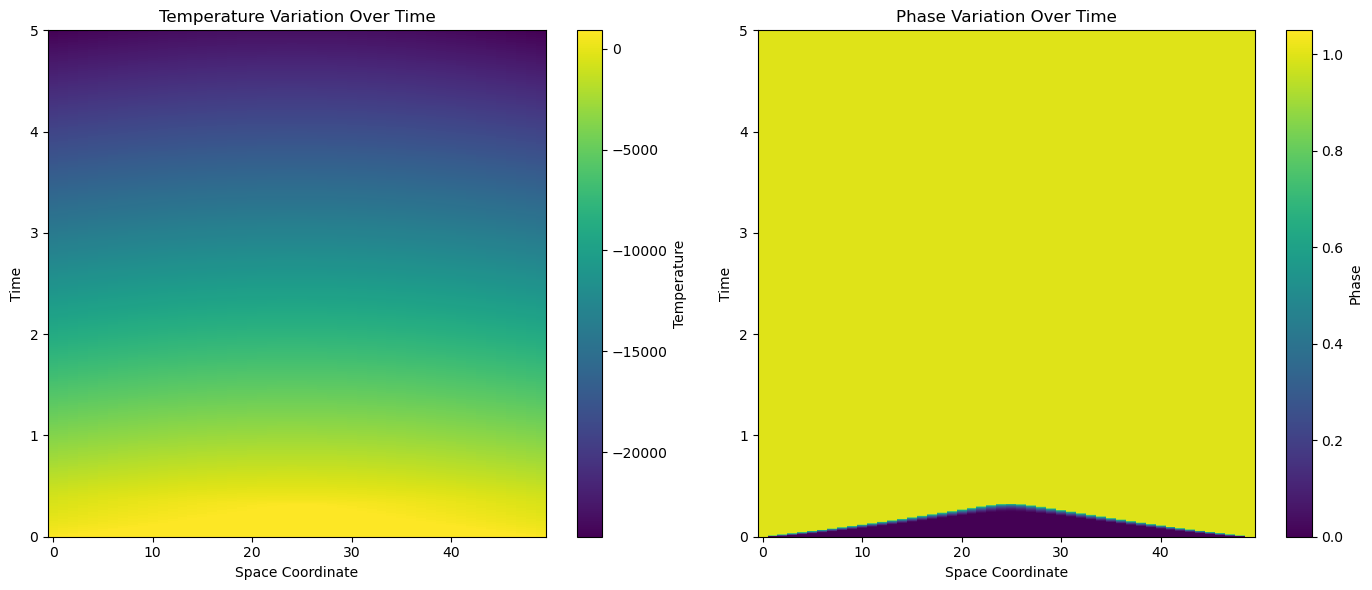

In [14]:
# Assuming you have temperature_history and phi_history as lists of arrays
temperature_history = np.array(temperature_history)
phi_history = np.array(phi_history)



# Check the new shape after transposing
print("Transposed Temperature History Shape:", temperature_history.shape)
print("Transposed Phi History Shape:", phi_history.shape)

# Create a meshgrid for space and time coordinates
space_coord, time_coord = np.meshgrid(np.arange(temperature_history.shape[1]), np.arange(temperature_history.shape[0]))

time_coord = time_coord * dt 
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the temperature history on the left subplot
im1 = ax1.pcolormesh(space_coord, time_coord, temperature_history, cmap='viridis')
ax1.set_xlabel('Space Coordinate')
ax1.set_ylabel('Time')
ax1.set_title('Temperature Variation Over Time')
fig.colorbar(im1, ax=ax1, label='Temperature')

# Plot the phase history on the right subplot
im2 = ax2.pcolormesh(space_coord, time_coord, phi_history, cmap='viridis')
ax2.set_xlabel('Space Coordinate')
ax2.set_ylabel('Time')
ax2.set_title('Phase Variation Over Time')
fig.colorbar(im2, ax=ax2, label='Phase')
plt.tight_layout()
plt.show()

# #plot the main
# fig, ax = plt.subplots(figsize=(14, 6))
# im = ax.pcolormesh(space_coord, time_coord, Niyama, cmap='viridis')
# ax.set_xlabel('Space Coordinate')
# ax.set_ylabel('Time')
# ax.set_title('Main Variation Over Time')
# fig.colorbar(im, ax=ax, label='Main')
# plt.tight_layout()
# plt.show()

### <center>Pareto analysis</center>

In this section sensitivity study of the soldification and Niyama is performed with respect to different material proerties and their boundary conditions.

A DOE table is created for different factors and their corresponding levels

Here the parameters are as follows:-

Density for material in liquid state $\rho_l$.<br>
Density for material in solid state $\rho_s$.<br>
Latent Heat of Fusion <br>
Specific heat of material in liquid state $C_{pl}$ <br>
Specific heat of material in solid state $C_{ps}$ <br>
Thermal Conductivity of material in liquid state $k_l$<br>
Thermal Conductivity of material in solid state $k_s$ <br>


Boundary conditions:-
BC at Left end,<br>
BC at Right end<br>

Initial Conditions:-

Initial_temperature

The simualtion of the 1D phase change is give temperature and phase change. The output/ target variable under study here is the Average solidification time of the entire geometry.

If Niyama criteria is being considered then some additional input factors are also considered such as:-

Material constant $C_\lambda$
Dynamic Viscosity $\mu_l$



Create a DOE table for Average Solidification Fraction at time t

In [ ]:
import pandas as pd
from pyDOE2 import fullfact

# Create a full factorial design
num_levels = 2
levels = [0, 1]
num_vars = 10
design = fullfact([num_levels]*num_vars)

# Create a DataFrame from the full factorial design
doe_df_sol_time = pd.DataFrame(design, columns=[f'Var_{i}' for i in range(1, num_vars+1)])
print(doe_df_sol_time.shape)

In [ ]:
#Create a fractional factorial design

from pyDOE2 import fracfact

num_levels = 2
levels = [0, 1]
num_vars = 10
design2 = fracfact('a b c d e f abcdef abcd bcde adce ')
scale = 0.1
factor_levels = {
    'rho_l': [2760.0, 2860.0],
    'rho_s': [2960.0, 3000.0],
    'k_l': [150.0, 160.0],
    'k_s': [170.0, 180.0],
    'cp_l': [963.0, 983.0],
    'cp_s': [993.0, 1000.0],
    'Left_bc': [313.0, 323.0],
    'right_bc': [400.0, 410.0],
    'L_fusion': [3.9e3, 4.0e3],
    'temp_init': [890.0, 900.0],

}

factor_names = list(factor_levels.keys())

# Create a DataFrame from the fractional factorial design
doe_df_sol_time_fracfact = pd.DataFrame(design2, columns=factor_names)

for factor, levels in factor_levels.items():
    doe_df_sol_time_fracfact[factor] = doe_df_sol_time_fracfact[factor].map({-1: levels[0], 1: levels[1]})

    
print(doe_df_sol_time_fracfact.shape)

Create a DOE table for Average Dimensionless Niyama Number at time t

In [ ]:
# Create a full factorial design
num_levels = 2
levels = [0, 1]
num_vars = 11
design = fullfact([num_levels]*num_vars)

# Create a DataFrame from the full factorial design
doe_df_niyama = pd.DataFrame(design, columns=[f'Var_{i}' for i in range(1, num_vars+1)])
print(doe_df_niyama .shape)

In [ ]:
Res_doe_sol_time = doe_df_sol_time_fracfact.copy()

Res_doe_sol_time['avg_sol_time'] = [0.0] * Res_doe_sol_time.shape[0]

print(Res_doe_sol_time.head(5))



Function for simulation

In [ ]:
# here the response values are calculated using sim1d function

for i in range(Res_doe_sol_time.shape[0]):
    input_values = Res_doe_sol_time.iloc[i,:-1].values
    Res_doe_sol_time.at[i, 'avg_sol_time'] = sim1d(*input_values)

In [ ]:
plt.hist(Res_doe_sol_time['avg_sol_time'], bins=10, alpha=0.5, color='b')
plt.title('Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

Anova of the DOE-Soldifcation time

In [ ]:
from statsmodels.formula.api import ols
# Create the formula for the ANOVA
formula = 'avg_sol_time ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + C(cp_l) + C(cp_s) + C(Left_bc) + C(right_bc) + C(L_fusion) + C(temp_init)'

# Fit the model
model = ols(formula, data=Res_doe_sol_time).fit()

# Perform ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA results
print(anova_results)
print(model.summary())

In [ ]:
# Create a DataFrame from the ANOVA results
anova_results_df = anova_results.reset_index()

# Sort by the F-statistic or sum of squares for visualization
anova_results_df = anova_results_df.sort_values(by='F', ascending=False)

# Plot the Pareto chart
plt.figure(figsize=(10, 6))
plt.bar(anova_results_df['index'], anova_results_df['F'], color='b')
plt.xlabel('Factors')
plt.ylabel('F-statistic')
plt.title('Pareto Chart of ANOVA F-statistics')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()